In [1]:
#load the libraries
import pandas as pd
import numpy as np
import pandas_profiling as pp
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv('forestfires.csv')
raw_data.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


Dummy variables are also present in this dataset. However we do not require them since we can use label encoding.

# EDA

In [3]:
df = raw_data.copy()
# Removing the dummies
df.drop(df.columns[11:30], axis = 1, inplace = True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


No Null Values

In [5]:
df.describe()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


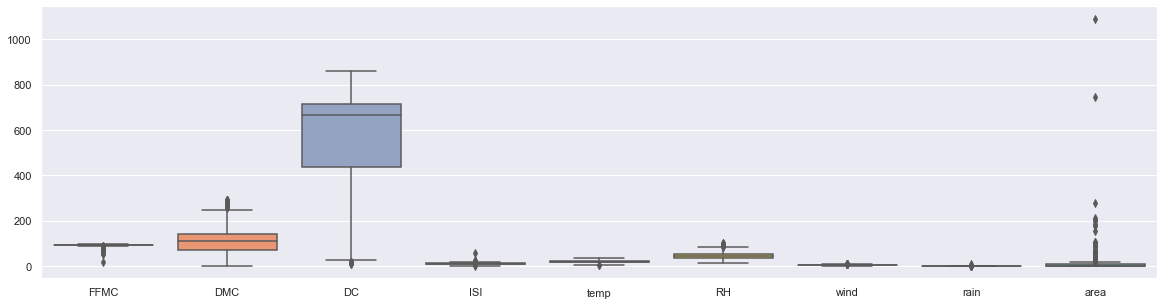

In [6]:
sns.set(rc = {'figure.figsize':(20, 5)})
sns.boxplot(data = df, orient = "v", palette = "Set2");

There are outliers in the case of area but we cannot discard it.

* Feature Analysis

In [7]:
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [8]:
df.size_category.value_counts()

small    378
large    139
Name: size_category, dtype: int64

The dataset is biased. Lets remove the bias.

In [9]:
# We are going to perform label encoding since it is faster than dummy variables

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df.month = label_encoder.fit_transform(df.month) 
df.day = label_encoder.fit_transform(df.day)
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,small
1,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,small
2,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,small
3,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,small
4,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,small


* Removing Bias in the Dataset

In [10]:
from imblearn.combine import SMOTETomek
from collections import Counter

resamp = df.copy()
#SMOTEK TECHNIQUE

#Define dataset
a = resamp.iloc[:, :-1]
b = resamp.iloc[:, -1]

#Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
a, b = smt.fit_resample(a, b)

#Count after
print(Counter(b))

Counter({'small': 378, 'large': 139})
Counter({'small': 374, 'large': 374})


Removed bias in dataset

In [11]:
# Train | Split dataset
X = a
y = b
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

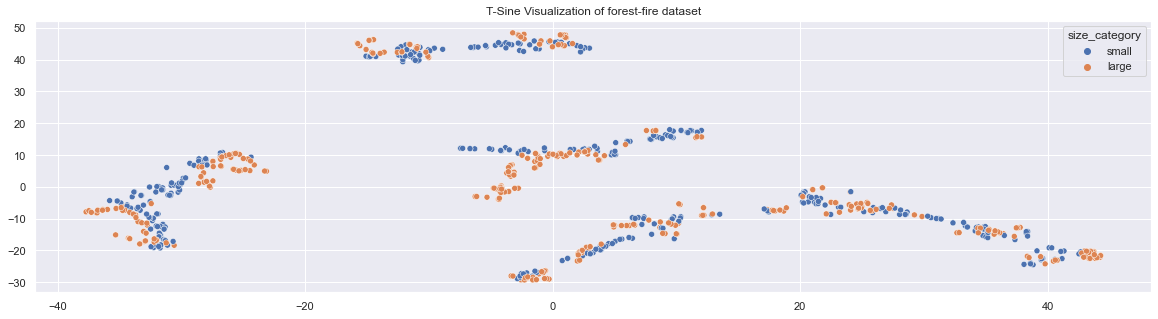

In [12]:
#Visualising the data via dimensionality reduction t-Sine Technique
from sklearn.manifold import TSNE

data_tsne_pca = TSNE(n_components = 2).fit_transform(a)
sns.scatterplot(data_tsne_pca[:, 0], data_tsne_pca[:,1], hue = b, 
                palette = "deep").set_title('T-Sine Visualization of forest-fire dataset');

# Support Vector Machine

In [13]:
from sklearn.svm import SVC
model = SVC(kernel = 'linear', C = 1000)
model.fit(X_train, y_train)

SVC(C=1000, kernel='linear')

* Model Evaluation

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

def report_model(model):
    model_preds = model.predict(X_test)
    print(confusion_matrix(y_test, model_preds))
    print(classification_report(y_test, model_preds))
    plot_confusion_matrix(model, X_test, y_test)

[[119   0]
 [  0 106]]
              precision    recall  f1-score   support

       large       1.00      1.00      1.00       119
       small       1.00      1.00      1.00       106

    accuracy                           1.00       225
   macro avg       1.00      1.00      1.00       225
weighted avg       1.00      1.00      1.00       225



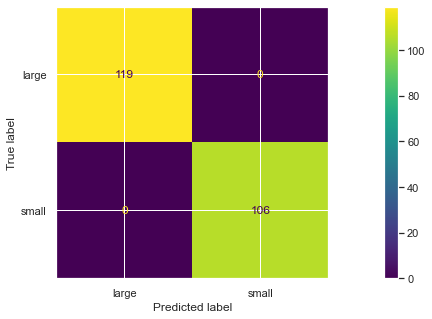

In [15]:
report_model(model)

* Experimenting with Hyperparameters

[[102  17]
 [  3 103]]
              precision    recall  f1-score   support

       large       0.97      0.86      0.91       119
       small       0.86      0.97      0.91       106

    accuracy                           0.91       225
   macro avg       0.91      0.91      0.91       225
weighted avg       0.92      0.91      0.91       225



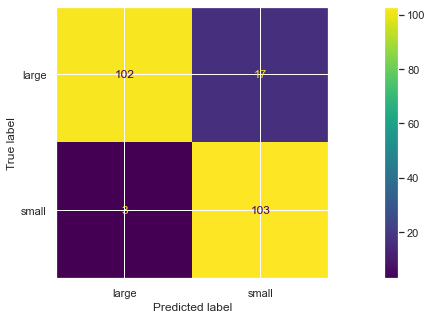

In [16]:
model1 = SVC(kernel = 'poly', C = 100)
model1.fit(X_train, y_train)
report_model(model1)

Reducing C values Reduces overall performance of model.

[[109  10]
 [  3 103]]
              precision    recall  f1-score   support

       large       0.97      0.92      0.94       119
       small       0.91      0.97      0.94       106

    accuracy                           0.94       225
   macro avg       0.94      0.94      0.94       225
weighted avg       0.94      0.94      0.94       225



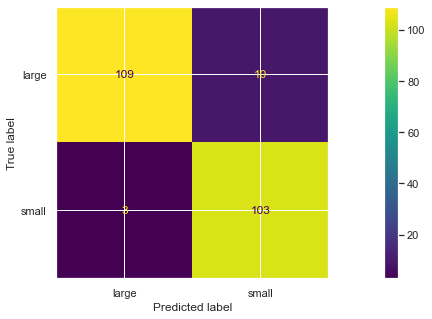

In [17]:
model2 = SVC(kernel = 'poly', C = 1000)
model2.fit(X_train, y_train)
report_model(model2)

Kernel Poly reduced performance of model. Linear seems to give the best results.

[[119   0]
 [  3 103]]
              precision    recall  f1-score   support

       large       0.98      1.00      0.99       119
       small       1.00      0.97      0.99       106

    accuracy                           0.99       225
   macro avg       0.99      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225



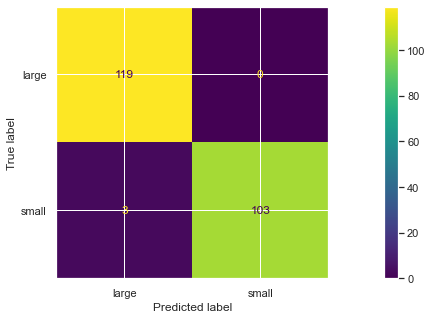

In [18]:
model3 = SVC(kernel = 'poly', gamma = 0.5, C = 1000)
model3.fit(X_train, y_train)
report_model(model3)

* Grid Search

In [19]:
from sklearn.model_selection import GridSearchCV

grid_model = SVC()
param_grid = [{'kernel':['rbf', 'poly', 'linear', 'sigmoid'], 'gamma':[50, 5, 10, 0.5], 
               'C':[1000, 600, 200, 100, 15, 10, 0.1, 0.001] }]
gsv = GridSearchCV(grid_model, param_grid, cv = 10)
gsv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid=[{'C': [1000, 600, 200, 100, 15, 10, 0.1, 0.001],
                          'gamma': [50, 5, 10, 0.5],
                          'kernel': ['rbf', 'poly', 'linear', 'sigmoid']}])

In [20]:
gsv.best_params_ , gsv.best_score_

({'C': 0.001, 'gamma': 50, 'kernel': 'linear'}, 0.9942670537010159)

# Final Model

[[119   0]
 [  3 103]]
              precision    recall  f1-score   support

       large       0.98      1.00      0.99       119
       small       1.00      0.97      0.99       106

    accuracy                           0.99       225
   macro avg       0.99      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225



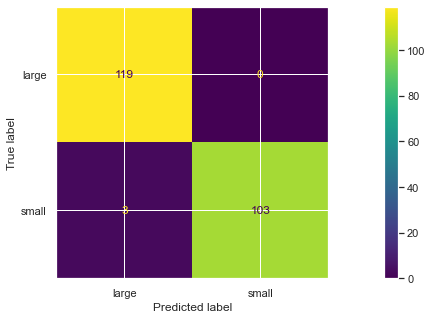

In [21]:
model_fnl = SVC(kernel = 'linear',gamma = 50, C = 0.001)
model_fnl.fit(X_train, y_train)
report_model(model_fnl)